In [8]:
! pip install torch-geometric

In [62]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from torch_geometric.utils import degree
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
from collections import defaultdict
from scipy import sparse

# **Load Dataset**

In [10]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'


Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [11]:
rating_df = pd.read_csv(rating_path)
print(rating_df.head())
print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))

rating_df.describe()

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
rating_df['userId'] = lbl_user.fit_transform(rating_df['userId'])
rating_df['movieId'] = lbl_movie.fit_transform(rating_df['movieId'])

In [14]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [15]:
rating_df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [16]:
def load_edge_csv(df, src_index_col, dst_index_col, link_index_col, rating_threshold=3):
  edge_index = None

  src = [user_id for user_id in df['userId']]
  dst = [movie_id for movie_id in df['movieId']]
  link_vals = df[link_index_col].values
  edge_attr = torch.from_numpy(df[link_index_col].values).view(-1,1).to(torch.long) >= rating_threshold
  edge_index = [[],[]]
  edge_vals = []
  for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
      edge_index[0].append(src[i])
      edge_index[1].append(dst[i])
      edge_vals.append(link_vals[i])

  return edge_index, edge_vals

In [17]:
edge_index, edge_values = load_edge_csv(rating_df, src_index_col='userId', dst_index_col='movieId', link_index_col='rating', rating_threshold=3.5)

print(f'{len(edge_index)} x {len(edge_index[0])}')

2 x 48580


In [18]:
edge_values = torch.tensor(edge_values)
edge_values.size()

torch.Size([48580])

In [19]:
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


In [20]:
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())
num_interactions = edge_index.shape[1]
print('Number of users: ', num_users)
print('Number of movies: ', num_movies)
print('Number of interactions: ', num_interactions)

Number of users:  610
Number of movies:  9724
Number of interactions:  48580


In [21]:
all_indices = [i for i in range(num_interactions)]
train_indices, test_indices = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=1,
)

val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=1,
)

train_edge_index = edge_index[:, train_indices]
train_edge_values = edge_values[train_indices]
val_edge_index = edge_index[:, val_indices]
val_edge_values = edge_values[val_indices]
test_edge_index = edge_index[:, test_indices]
test_edge_values = edge_values[test_indices]

In [22]:
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

torch.Size([609])
torch.Size([5676])


In [23]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
  R = torch.zeros((num_users, num_movies))
  for i in range(len(input_edge_index[0])):
    row, col = input_edge_index[0][i], input_edge_index[1][i]
    R[row, col] = input_edge_values[i]
  R_transpose = torch.transpose(R, 0, 1)
  adj_mat = torch.zeros((num_users+num_movies, num_users+num_movies))
  adj_mat[:num_users, num_users:] = R.clone()
  adj_mat[num_users:, :num_users] = R_transpose.clone()
  adj_mat_coo = adj_mat.to_sparse_coo()
  return adj_mat_coo.indices(), adj_mat_coo.values()

In [24]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
  input_edge_index = input_edge_index.to(device)
  input_edge_values = input_edge_values.to(device)
  sparse_input_edge_index = torch.sparse_coo_tensor(input_edge_index, input_edge_values, size=(num_users+num_movies, num_users+num_movies))
  sparse_input_edge_index.to(device)
  A = sparse_input_edge_index.to_dense()
  R = A[:num_users, num_users:]
  R_coo = R.to_sparse_coo()
  return R_coo.indices(), R_coo.values()

In [25]:
train_adj_edge_index, train_adj_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_values)
val_adj_edge_index, val_adj_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_values)
test_adj_edge_index, test_adj_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_values)

In [26]:
print(train_edge_index.size())
print(val_edge_index.size())
print(test_edge_index.size())

torch.Size([2, 38864])
torch.Size([2, 4858])
torch.Size([2, 4858])


In [27]:
def sample_mini_batch(edge_index, batch_size):
  edges = structured_negative_sampling(edge_index)

  edges = torch.stack(edges,dim=0)
  indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)

  batch = edges[:, indices]
  user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
  return user_indices, pos_item_indices, neg_item_indices

In [51]:
class LightGCN(MessagePassing):

  def __init__(self, num_users, num_movies, embedding_dim=64, X=3, add_self_loops=False):
    super().__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_dim = embedding_dim
    self.X = X
    self.add_self_loops = add_self_loops

    self.users_embedding = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
    self.items_embedding = nn.Embedding(num_embeddings=self.num_movies, embedding_dim=self.embedding_dim)

    nn.init.normal_(self.users_embedding.weight, std=0.1)
    nn.init.normal_(self.items_embedding.weight, std=0.1)
    
    self.out = nn.Linear(embedding_dim*2, 1)

  def forward(self, edge_index, edge_values):
    edge_index = edge_index.to(device)
    edge_values = edge_values.to(device)
    edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

    emb_0 = torch.cat([self.users_embedding.weight, self.items_embedding.weight])
    embs = [emb_0]
    emb_k = emb_0

    for i in range(self.X):
      emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
      emb_k = emb_k.to(device)
      embs.append(emb_k)

    embs = torch.stack(embs, dim=1)
    lightgcn_all_embeddings = torch.mean(embs, dim=1)

    user_embeddings, movie_embeddings = torch.split(lightgcn_all_embeddings, [self.num_users, self.num_movies])
    
    r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)
    
    src, dest = r_mat_edge_index[0], r_mat_edge_index[1]
    user_embs = user_embeddings[src]
    item_embs = movie_embeddings[dest]
    out = torch.cat([user_embs, item_embs], dim=1)
    return self.out(out)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [53]:
def get_recall_at_k(input_edge_index, input_edge_values, pred_ratings, k=10, threshold=3.5):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)
        for i in range(len(input_edge_index[0])):
            src=input_edge_index[0][i].item()
            dest=input_edge_index[1][i].item()
            true_rating=input_edge_values[i].item()
            pred_rating=pred_ratings[i].item()
            
            user_item_rating_list[src].append((pred_rating, true_rating))
        recalls = dict()
        precisions = dict()
        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r>=threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est>=threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum((est>=threshold and true_r>=threshold) for (est, true_r) in user_ratings[:k])
            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        overall_recall = sum(rec for rec in recalls.values())/len(recalls)
        overall_precision = sum(pre for pre in precisions.values())/len(precisions)
        
        return overall_recall, overall_precision

In [54]:
def get_user_positive_items(edge_index):
  user_pos_items = {}
  for i in range(edge_index.shape[1]):
    user = edge_index[0][i].item()
    item = edge_index[1][i].item()
    if user not in user_pos_items:
      user_pos_items[user] = []
      user_pos_items[user].append(item)
  return user_pos_items

In [55]:
def RecallPrecision_ATk(groundTruth, r, k):
  assert len(r) == len(groundTruth)  
  num_correct_pred = torch.sum(r, dim=-1)
  user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
  recall = torch.mean(num_correct_pred / user_num_liked)
  precision = torch.mean(num_correct_pred / k)
  return recall.item(), precision.item()

In [56]:
Iterations = 10000
Epochs = 10
Batch_size = 1024
lr = 1e-3
lambda_val = 1e-6
k = 10
iters_per_lr_decay = 200
iters_per_eval = 100

In [57]:
def bpr_loss(users_emb_fin, users_emb_0, pos_items_emb_fin,pos_items_emb_0 , neg_items_emb_fin, neg_items_emb_0, lambda_val):
  reg_loss = lambda_val*(users_emb_0.norm(2).pow(2) + pos_items_emb_0.norm(2).pow(2) + neg_items_emb_0.norm(2).pow(2))
  pos_scores = torch.mul(users_emb_fin, pos_items_emb_fin)
  pos_scores = torch.sum(pos_scores, dim=1)
  neg_scores = torch.mul(users_emb_fin, neg_items_emb_fin)
  neg_scores = torch.sum(neg_scores, dim=1)
  bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))
  return bpr_loss + reg_loss

In [58]:
print(f'Using device {device}')
layers = 2
model = LightGCN(num_users=num_users, num_movies=num_movies, X=layers)
model = model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)
test_adj_edge_index = test_adj_edge_index.to(device)

train_adj_edge_values = train_adj_edge_values.to(device)
val_adj_edge_values = val_adj_edge_values.to(device)
test_adj_edge_values = test_adj_edge_values.to(device)
loss_fn = nn.MSELoss()

Using device cuda


In [59]:
def NDCGat_K_r(groundTruth, r, k):
  assert len(r) == len(groundTruth)
  test_mat = torch.zeros((len(r), k))
  for i, items in enumerate(groundTruth):
    length = min(len(items), k)
    test_mat[i, :length] = 1

  max_r = test_mat
  idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
  dcg = torch.sum(r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
  ndcg = dcg/idcg
  ndcg[torch.isnan(ndcg)] = 0
  return torch.mean(ndcg).item()

In [60]:
r_mat_train_index, r_mat_train_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_adj_edge_index, train_adj_edge_values)
r_mat_test_index, r_mat_test_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_adj_edge_index, test_adj_edge_values)
r_mat_val_index, r_mat_val_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_adj_edge_index, val_adj_edge_values)

In [63]:
# Train the model
train_losses = []
val_losses = []
val_recall_at_k = []
val_precision_at_k = []

for iter in tqdm(range(Iterations)):
  pred_ratings = model.forward(train_adj_edge_index, train_adj_edge_values)
  train_loss = loss_fn(pred_ratings, r_mat_train_values.view(-1, 1))
    
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  # val set
  if iter % iters_per_eval == 0:
    model.eval()

    with torch.no_grad():
      val_pred_ratings = model.forward(val_adj_edge_index, val_adj_edge_values)
      val_loss = loss_fn(val_pred_ratings, r_mat_val_values.view(-1, 1)).sum()
      recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_index, r_mat_val_values, val_pred_ratings, k=20)
      print(f"[Iteration {iter}/{Iterations}] train_loss: {train_loss}, val_Loss: {val_loss}, Recall: {recall_at_k}, Precision: {precision_at_k}")

      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())
      val_recall_at_k.append(recall_at_k)
      val_precision_at_k.append(precision_at_k)

    model.train()

  if iter % iters_per_lr_decay == 0 and iter != 0:
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000] train_loss: 19.466066360473633, val_Loss: 19.287357330322266, Recall: 0.0, Precision: 0.0
[Iteration 100/10000] train_loss: 2.6039252281188965, val_Loss: 3.723226308822632, Recall: 0.004981536914450106, Precision: 0.05605786618444846
[Iteration 200/10000] train_loss: 0.7845657467842102, val_Loss: 1.3154675960540771, Recall: 0.2767483781775508, Precision: 0.6148282097649186
[Iteration 300/10000] train_loss: 0.6038181781768799, val_Loss: 1.1365898847579956, Recall: 0.4124823468794636, Precision: 0.7468354430379747
[Iteration 400/10000] train_loss: 0.4904470443725586, val_Loss: 1.062321662902832, Recall: 0.47773867726594166, Precision: 0.7811934900542495
[Iteration 500/10000] train_loss: 0.40070217847824097, val_Loss: 1.0194536447525024, Recall: 0.5398868643085531, Precision: 0.7992766726943942
[Iteration 600/10000] train_loss: 0.32319173216819763, val_Loss: 0.9949789643287659, Recall: 0.5722006213263839, Precision: 0.7884267631103075
[Iteration 700/10000] train_loss: 

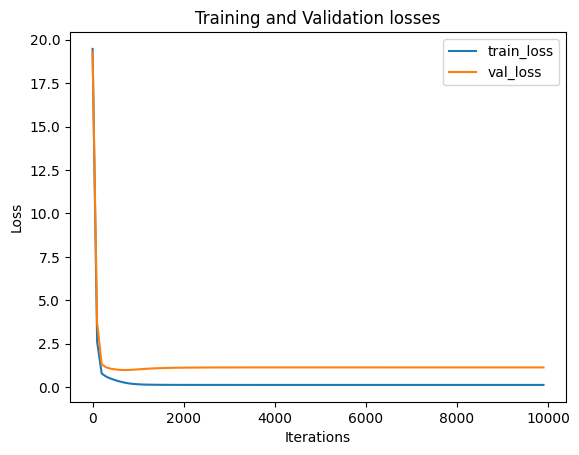

In [65]:
iters = [iter* iters_per_eval for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train_loss')
plt.plot(iters, val_losses, label='val_loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation losses')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

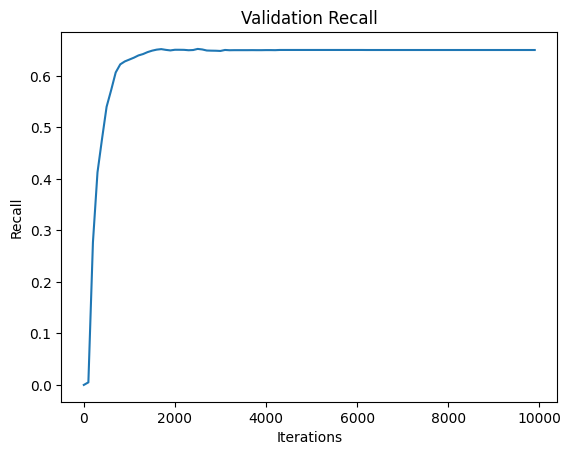

In [67]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_k, label='val_recall')
plt.xlabel('Iterations')
plt.ylabel('Recall')
plt.title('Validation Recall')
plt.show

In [68]:
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_adj_edge_index, test_adj_edge_values)
    test_recall, test_precision = get_recall_at_k(r_mat_test_index, r_mat_test_values, pred_ratings, 20)
    print(f"Recall: {test_recall}, Precision: {test_precision}")

Recall: 0.6400040691098957, Precision: 0.8206521739130435
